Of course. Here is a high-level, cell-by-cell outline for the Level 2 dataset creation notebook, designed to implement your "triplet" strategy.

---

### **Notebook Outline: Level 2 Dataset Preparation**

**Part 1: Setup and Configuration**

*   **Cell 1.1: Imports and Global Setup.**
    *   Import necessary libraries (`json`, `pandas`, `pathlib`, `datasets`, etc.).
    *   Define project root and I/O directories, identical to the Level 1 script.
*   **Cell 1.2: Define Label Mapping.**
    *   Explicitly define the class-to-integer mapping in a dictionary for clarity.
    *   `LABEL_MAP = {"correct": 0, "conceptual": 1, "computational": 2}`.

**Part 2: Data Loading**

*   **Cell 2.1: Load Raw Data Sources.**
    *   Load the manual errors CSV (`manually_generated_errors_final.csv`).
    *   Load the programmatic computational error catalog (`computational_error_catalog.csv`).
    *   Load the original GSM8K dataset to retrieve correct answers.
    *   Print counts for each source.

**Part 3: Data Preparation Pipeline**

*   **Cell 3.1: Build Master Index and Data Lookups.**
    *   **Goal:** Create the set of problem indices that will form the basis of our dataset.
    *   **Action:** Scan the manual errors CSV and identify all unique problem indices that have at least one `conceptual` error. This set, `anchor_indices`, will be our master list (`N ≈ 1000`).
    *   **Action:** Create a `gsm8k_lookup` dictionary for easy access to the original "correct" question/answer pairs.
*   **Cell 3.2: Prepare "Correct" and "Conceptual" Samples.**
    *   **Goal:** Create the first two-thirds of the dataset.
    *   **Action:** Iterate through each `idx` in `anchor_indices`.
    *   For each `idx`, add the "Correct" sample (Label 0) from `gsm8k_lookup`.
    *   For each `idx`, find the corresponding manual `conceptual` error and add it as a sample (Label 1). Handle cases where an index might have multiple conceptual errors by randomly selecting one.
*   **Cell 3.3: Prepare "Computational" Samples (Hierarchical Sourcing).**
    *   **Goal:** Create the final third of the dataset, ensuring every anchor index gets one computational error.
    *   **Action:** Iterate through each `idx` in `anchor_indices`.
    *   **First, check for a manual computational error:** Look in the manual errors CSV for a `computational` error with that `idx`. If found, add it as a sample (Label 2) and move to the next index.
    *   **If not found, source from the programmatic catalog:** Query the programmatic catalog for a valid computational error file for that `idx`. If found, load the `flawed_nl_solution` from the JSON file, create the sample (Label 2), and add it.
    *   **Handle missing data:** Keep track of any indices for which no computational error could be found.
*   **Cell 3.4: Final Assembly and Verification.**
    *   **Goal:** Combine all generated samples and verify the class balance.
    *   **Action:** Merge the lists of "Correct", "Conceptual", and "Computational" samples into a single list (`final_dataset_list`).
    *   **Action:** Print the final counts for each label (0, 1, 2) to confirm the 1:1:1 balance.
    *   **Action:** Save a metadata catalog CSV, similar to the Level 1 script, but with the new label scheme.

**Part 4: Dataset Splitting and Saving**

*   **Cell 4.1: Split and Save the Dataset.**
    *   **Goal:** Split the data into train/validation/test sets based on `index` to prevent leakage.
    *   **Action:** Use the `split_dataset_by_index` function from the Level 1 script on `final_dataset_list`.
    *   **Action:** Save the final `DatasetDict` to disk.
    *   **Action:** Print the final structure of the saved dataset.

**Part 5: Verification**

*   **Cell 5.1: Inspect Random Triplets.**
    *   **Goal:** Visually inspect the generated data for correctness.
    *   **Action:** Create a `display_triplet_samples` function that selects a random `index`, finds the corresponding "Correct", "Conceptual", and "Computational" samples from `final_dataset_list`, and prints all three for comparison. Run this for a few random indices.

# Level 2 SFT Dataset Preparation

This notebook prepares the dataset for the Level 2 fine-tuning task. The goal is to create a 3-class classification dataset with the following labels:
-   `0`: Correct
-   `1`: Conceptual Error
-   `2`: Computational Error

The script will generate a perfectly balanced dataset with a 1:1:1 ratio across the three classes, using a "triplet" structure where each problem index is represented by one sample from each class.

## 1. Setup and Configuration

### 1.1 Imports and Global Paths

In [71]:
# --- 1.1: Imports and Global Paths ---
import json
import random
import re
from pathlib import Path
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

def find_project_root(marker: str = ".git") -> Path:
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = DATA_DIR / "sft-datasets/level-2-three-class"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Dataset output directory: {OUTPUT_DIR}")

Project root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Dataset output directory: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-2-three-class


### 1.2 Define Label Mapping

In [72]:
# --- 1.2: Define Label Mapping ---
LABEL_MAP = {
    "correct": 0,
    "conceptual": 1,
    "computational": 2,
}

print("Label mapping defined:")
print(LABEL_MAP)

Label mapping defined:
{'correct': 0, 'conceptual': 1, 'computational': 2}


## 2. Data Loading

In [73]:
# --- 2.1: Load Raw Data Sources ---

# Load the comprehensive CSV of all manually generated/annotated errors
MANUAL_ERRORS_CSV_PATH = DATA_DIR / "manually_generated_errors_final.csv"
manual_errors_df = pd.read_csv(MANUAL_ERRORS_CSV_PATH)

# Load the catalog of all programmatically generated computational errors
PROGRAMMATIC_COMP_CATALOG_PATH = DATA_DIR / "computational-errors-generated/computational_error_catalog.csv"
programmatic_catalog_df = pd.read_csv(PROGRAMMATIC_COMP_CATALOG_PATH)

# Load the original GSM8K training set for correct answers
GSM8K_TRAIN_DATASET: Dataset = load_dataset("gsm8k", "main", split="train")

print(f"Loaded {len(manual_errors_df):,} records from manual error CSV.")
print(f"Loaded {len(programmatic_catalog_df):,} records from programmatic computational catalog.")
print(f"Loaded {len(GSM8K_TRAIN_DATASET):,} samples from gsm8k/main train split.")

Loaded 1,963 records from manual error CSV.
Loaded 16,506 records from programmatic computational catalog.
Loaded 7,473 samples from gsm8k/main train split.


## 3. Data Preparation Pipeline

### 3.1 Define Core Data Pipeline Functions

In [42]:
# --- 3.1: Define Core Data Pipeline Functions ---

def sanitize_commas(text: str) -> str:
    """Removes comma separators from numbers to prevent model artifacts."""
    return re.sub(r'(\d),(\d)', r'\1\2', text)

def prepare_conceptual_and_correct_samples(
    anchor_indices: list[int],
    manual_errors_df: pd.DataFrame,
    gsm8k_lookup: dict,
    label_map: dict,
    seed: int = 42
) -> tuple[list[dict], list[dict]]:
    """
    For each anchor index, prepares a 'correct' sample and a 'conceptual' error sample.
    """
    samples, metadata = [], []
    rng = random.Random(seed)
    
    conceptual_df = manual_errors_df[
        (manual_errors_df['error_type'] == 'conceptual') &
        (manual_errors_df['index'].isin(anchor_indices))
    ]

    for idx in anchor_indices:
        # --- START OF FIX ---
        py_idx = int(idx) # Convert numpy.int64 to standard Python int
        # --- END OF FIX ---
        
        # 1. Add the "Correct" sample
        original_problem = gsm8k_lookup[py_idx]
        samples.append({
            "index": py_idx, "question": original_problem['question'],
            "solution": sanitize_commas(original_problem['answer']),
            "label": label_map['correct']
        })
        metadata.append({
            "index": py_idx, "label": label_map['correct'], "error_type": "correct",
            "source_file": "gsm8k.main.train"
        })

        # 2. Add the "Conceptual" sample
        candidate_rows = conceptual_df[conceptual_df['index'] == py_idx]
        chosen_row = candidate_rows.sample(n=1, random_state=rng.randint(0, 10**9)).iloc[0]
        samples.append({
            "index": py_idx, "question": chosen_row['question'],
            "solution": sanitize_commas(chosen_row['wrong_answer']),
            "label": label_map['conceptual']
        })
        metadata.append({
            "index": py_idx, "label": label_map['conceptual'], "error_type": 'conceptual',
            "source_file": chosen_row['filepath']
        })
        
    return samples, metadata

print("Core data pipeline functions defined.")

Core data pipeline functions defined.


### 3.2 Build Master Index and Data Lookups

In [43]:
# --- 3.2: Build Master Index and Data Lookups ---

# Identify all unique problem indices that have a manual conceptual error.
# These indices will form the foundation of our "triplet" dataset.
anchor_indices = sorted(list(
    manual_errors_df[manual_errors_df['error_type'] == 'conceptual']['index'].unique()
))

# Create a lookup dictionary for original GSM8K problems for fast access.
gsm8k_lookup = {
    i: {"question": q, "answer": a}
    for i, (q, a) in enumerate(zip(GSM8K_TRAIN_DATASET["question"], GSM8K_TRAIN_DATASET["answer"]))
}

print(f"Identified {len(anchor_indices)} anchor indices with manual conceptual errors.")

Identified 1030 anchor indices with manual conceptual errors.


### 3.3 Prepare "Correct" and "Conceptual" Samples

In [44]:
# --- 3.3: Prepare "Correct" and "Conceptual" Samples ---

# Use the utility function to generate the first two legs of our triplets.
base_samples, base_metadata = prepare_conceptual_and_correct_samples(
    anchor_indices=anchor_indices,
    manual_errors_df=manual_errors_df,
    gsm8k_lookup=gsm8k_lookup,
    label_map=LABEL_MAP
)

print(f"Generated {len(base_samples)} samples for 'Correct' and 'Conceptual' classes.")
print(f"Total unique problems: {len(base_samples) // 2}")

Generated 2060 samples for 'Correct' and 'Conceptual' classes.
Total unique problems: 1030


### 3.4 Define "Computational" Sample Preparation Function

In [45]:
# --- 3.4: Define "Computational" Sample Preparation Function ---

def prepare_computational_samples(
    anchor_indices: list[int],
    manual_errors_df: pd.DataFrame,
    programmatic_catalog_df: pd.DataFrame,
    gsm8k_lookup: dict,
    label_map: dict,
    project_root: Path
) -> tuple[list[dict], list[dict], list[int]]:
    """
    For each anchor index, sources one 'computational' error sample.
    It prioritizes manually generated errors, then falls back to programmatic ones.
    """
    samples, metadata = [], []
    unfound_indices = []
    
    manual_comp_df = manual_errors_df[manual_errors_df['error_type'] == 'computational'].set_index('index')
    
    prog_comp_lookup = {
        row['index']: row['filepath']
        for _, row in programmatic_catalog_df.iterrows()
        if pd.notna(row['filepath'])
    }
    
    print("Sourcing computational errors...")
    for idx in anchor_indices:
        # --- START OF FIX ---
        py_idx = int(idx) # Convert numpy.int64 to standard Python int
        # --- END OF FIX ---
        
        found = False
        if py_idx in manual_comp_df.index:
            result = manual_comp_df.loc[py_idx]
            if isinstance(result, pd.DataFrame):
                chosen_row = result.iloc[0]
            else:
                chosen_row = result
                
            question = chosen_row['question']
            flawed_solution = chosen_row['wrong_answer']
            source_file = chosen_row['filepath']
            found = True
        elif py_idx in prog_comp_lookup:
            try:
                filepath = project_root / prog_comp_lookup[py_idx]
                with open(filepath, 'r') as f:
                    flawed_solution = json.load(f)["flawed_nl_solution"]
                question = gsm8k_lookup[py_idx]['question']
                source_file = prog_comp_lookup[py_idx]
                found = True
            except (FileNotFoundError, KeyError, json.JSONDecodeError):
                pass

        if found:
            samples.append({
                "index": py_idx, "question": question,
                "solution": sanitize_commas(flawed_solution),
                "label": label_map['computational']
            })
            metadata.append({
                "index": py_idx, "label": label_map['computational'], "error_type": 'computational',
                "source_file": source_file
            })
        else:
            unfound_indices.append(py_idx)
            
    return samples, metadata, unfound_indices

print("Computational sample preparation function defined.")

Computational sample preparation function defined.


### 3.5 Prepare "Computational" Samples

In [46]:
# --- 3.5: Prepare "Computational" Samples ---

# Use the utility function to generate the final leg of our triplets.
computational_samples, computational_metadata, unfound_indices = prepare_computational_samples(
    anchor_indices=anchor_indices,
    manual_errors_df=manual_errors_df,
    programmatic_catalog_df=programmatic_catalog_df,
    gsm8k_lookup=gsm8k_lookup,
    label_map=LABEL_MAP,
    project_root=PROJECT_ROOT
)

print(f"\nGenerated {len(computational_samples)} 'Computational' error samples.")
if unfound_indices:
    print(f"Warning: Could not find a computational error for {len(unfound_indices)} indices.")
    print(f"Sample of unfound indices: {unfound_indices[:5]}")

Sourcing computational errors...

Generated 973 'Computational' error samples.
Sample of unfound indices: [10, 11, 29, 37, 145]


### 3.6 Final Assembly and Verification

In [47]:
# --- 3.6: Final Assembly and Verification ---

# Combine the samples from all three classes
final_dataset_list = base_samples + computational_samples
final_metadata_list = base_metadata + computational_metadata

# Verify class balance
final_df = pd.DataFrame(final_dataset_list)
print("--- Final Dataset Class Distribution ---")
print(final_df['label'].value_counts().sort_index())
print("\nMapping:")
for class_name, label_int in LABEL_MAP.items():
    print(f"  {label_int}: {class_name}")

# Save the combined metadata catalog
metadata_df = pd.DataFrame(final_metadata_list)
CATALOG_PATH = OUTPUT_DIR / "sft_level2_catalog.csv"
metadata_df.to_csv(CATALOG_PATH, index=False)
print(f"\nMetadata catalog with {len(metadata_df)} records saved to: {CATALOG_PATH}")

--- Final Dataset Class Distribution ---
label
0    1030
1    1030
2     973
Name: count, dtype: int64

Mapping:
  0: correct
  1: conceptual
  2: computational

Metadata catalog with 3033 records saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-2-three-class/sft_level2_catalog.csv


## 4. Dataset Splitting and Saving

### 4.1 Split and Save the Dataset

In [48]:
# --- 4.1: Split and Save the Dataset ---

def split_dataset_by_index(dataset_list: list[dict], train_size: float = 0.8, seed: int = 42) -> DatasetDict:
    """
    Splits a list of samples into train, validation, and test sets based on
    the problem 'index' to prevent data leakage between splits.
    All samples (correct, conceptual, computational) for a given index will
    be placed in the same split.
    """
    # Get a unique list of all problem indices in the dataset
    all_indices = sorted(list(set(item['index'] for item in dataset_list)))
    random.Random(seed).shuffle(all_indices)
    
    # Calculate the split points
    train_end = int(len(all_indices) * train_size)
    val_end = train_end + int((len(all_indices) - train_end) / 2)
    
    # Create sets of indices for each split
    train_indices = set(all_indices[:train_end])
    val_indices = set(all_indices[train_end:val_end])
    test_indices = set(all_indices[val_end:])
    
    # Partition the full dataset list based on the index sets
    train_data = [item for item in dataset_list if item['index'] in train_indices]
    val_data = [item for item in dataset_list if item['index'] in val_indices]
    test_data = [item for item in dataset_list if item['index'] in test_indices]
    
    return DatasetDict({
        "train": Dataset.from_list(train_data),
        "validation": Dataset.from_list(val_data),
        "test": Dataset.from_list(test_data)
    })

# Shuffle the master list before splitting to ensure randomness within each epoch.
# Note: The split_dataset_by_index function handles the split randomness itself.
# This shuffle is for the benefit of the Trainer's data loader.
random.Random(42).shuffle(final_dataset_list)

# Perform the split
print("Splitting final dataset and saving to disk...")
sft_dataset = split_dataset_by_index(final_dataset_list, train_size=0.8)

# Save the final DatasetDict to disk
sft_dataset.save_to_disk(OUTPUT_DIR)
print(f"-> Dataset splits successfully saved to: {OUTPUT_DIR}")

print("\n--- Final Dataset Structure ---")
print(sft_dataset)

Splitting final dataset and saving to disk...


Saving the dataset (0/1 shards):   0%|          | 0/2426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/302 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/305 [00:00<?, ? examples/s]

-> Dataset splits successfully saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-2-three-class

--- Final Dataset Structure ---
DatasetDict({
    train: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 2426
    })
    validation: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 302
    })
    test: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 305
    })
})


## 5. Inspect Random Triplets

In [49]:
# --- 5.1: Inspect Random Triplets ---

def display_triplet_samples(dataset_list: list[dict], n: int = 3, seed: int = 42):
    """
    Selects n random problem indices and displays the corresponding correct,
    conceptual, and computational samples for verification.
    """
    if not dataset_list:
        print("Error: Dataset list is empty.")
        return

    unique_indices = sorted(list(set(item['index'] for item in dataset_list)))
    if not unique_indices:
        print("Dataset contains no valid indices.")
        return
        
    n = min(n, len(unique_indices))
    random.Random(seed).shuffle(unique_indices)
    random_indices_to_display = unique_indices[:n]
    
    print(f"--- Displaying {n} random sample triplets for inspection ---")
    
    for i, problem_index in enumerate(random_indices_to_display):
        print(f"\n{'='*25} Triplet {i + 1}/{n} (Problem Index: {problem_index}) {'='*25}")
        
        # Find all samples for the current index
        triplet = [item for item in dataset_list if item.get('index') == problem_index]
        triplet.sort(key=lambda x: x['label']) # Sort by label: 0, 1, 2
        
        if len(triplet) != 3:
            print(f"Warning: Expected 3 samples for index {problem_index}, but found {len(triplet)}. Skipping.")
            continue
        
        print("\n--- Correct (Label 0) ---")
        print(json.dumps(triplet[0], indent=2, ensure_ascii=False))
        
        print("\n--- Conceptual (Label 1) ---")
        print(json.dumps(triplet[1], indent=2, ensure_ascii=False))

        print("\n--- Computational (Label 2) ---")
        print(json.dumps(triplet[2], indent=2, ensure_ascii=False))

    print("\n" + "=" * 70)

In [50]:
# Inspect 3 random triplets from the full, unsplit dataset list
display_triplet_samples(final_dataset_list, n=3)

--- Displaying 3 random sample triplets for inspection ---

========================= Triplet 1/3 (Problem Index: 1280) =========================

--- Correct (Label 0) ---
{
  "index": 1280,
  "question": "Honey earned $80 a day. Every day, she spent part of her pay and saved the rest. After 20 days of work, she spent $1360. How much did Honey save in 20 days?",
  "solution": "Honey earned 20 x $80 = $<<20*80=1600>>1600 for 20 days of work.\nTherefore, Honey saved $1600 - $1360 = $<<1600-1360=240>>240 in 20 days.\n#### 240",
  "label": 0
}

--- Conceptual (Label 1) ---
{
  "index": 1280,
  "question": "Honey earned $80 a day. Every day, she spent part of her pay and saved the rest. After 20 days of work, she spent $1360. How much did Honey save in 20 days?",
  "solution": "Honey earned 20 x $80 = $<<20*80=1600>>1600 for 20 days of work.\nTherefore, Honey saved $1600 + $1360 = $<<1600+1360=2960>>2960 in 20 days.\n#### 2960",
  "label": 1
}

--- Computational (Label 2) ---
{
  "index": 

In [74]:
baseline_preds = pd.read_csv(OUTPUT_DIR / "phi4-mini-level-2-baseline-preds.csv")
finetuned_preds = pd.read_csv(OUTPUT_DIR / "phi4-mini-level-2-finetuned-preds.csv")

In [76]:
print(baseline_preds.columns)
print(finetuned_preds.columns)

Index(['index', 'true_label', 'p(class=0)', 'p(class=1)', 'p(class=2)'], dtype='object')
Index(['index', 'true_label', 'p(class=0)', 'p(class=1)', 'p(class=2)'], dtype='object')


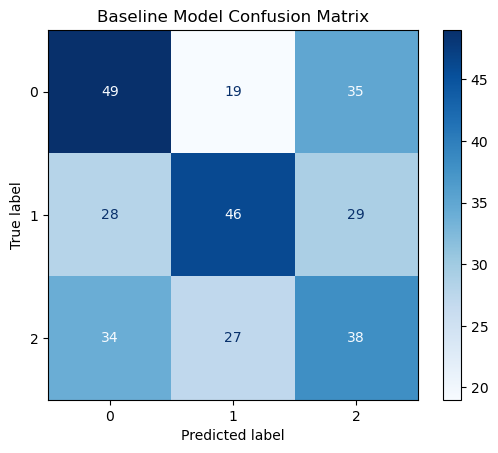

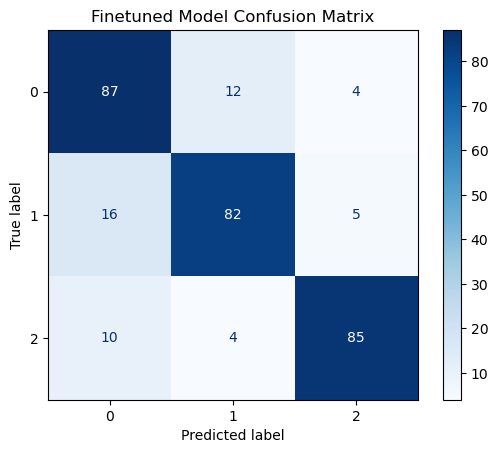

In [77]:
# ...existing code...

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predicted_labels(df):
    prob_cols = ['p(class=0)', 'p(class=1)', 'p(class=2)']
    return np.argmax(df[prob_cols].values, axis=1)

def plot_confusion(true, pred, title):
    cm = confusion_matrix(true, pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

# Baseline
baseline_true = baseline_preds['true_label'].values
baseline_pred = get_predicted_labels(baseline_preds)
plot_confusion(baseline_true, baseline_pred, "Baseline Model Confusion Matrix")

# Finetuned
finetuned_true = finetuned_preds['true_label'].values
finetuned_pred = get_predicted_labels(finetuned_preds)
plot_confusion(finetuned_true, finetuned_pred, "Finetuned Model Confusion Matrix")
# ...existing code...

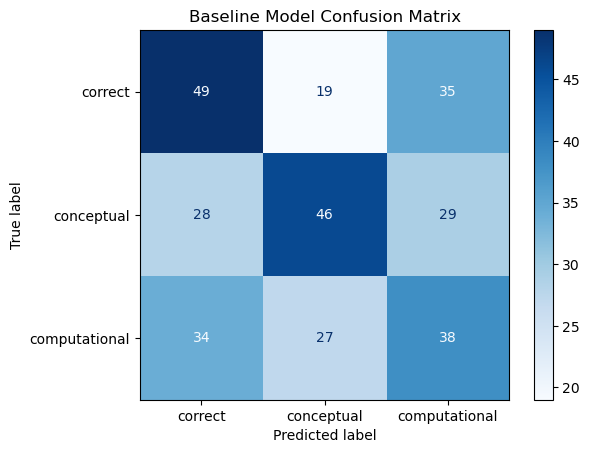

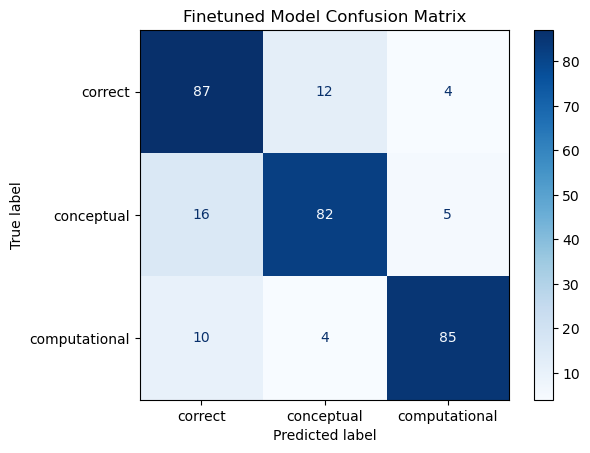

In [78]:
# ...existing code...

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Invert LABEL_MAP to get int -> name mapping, sorted by label int
label_names = [name for name, _ in sorted(LABEL_MAP.items(), key=lambda x: x[1])]

def get_predicted_labels(df):
    prob_cols = ['p(class=0)', 'p(class=1)', 'p(class=2)']
    return np.argmax(df[prob_cols].values, axis=1)

def plot_confusion(true, pred, title):
    cm = confusion_matrix(true, pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

# Baseline
baseline_true = baseline_preds['true_label'].values
baseline_pred = get_predicted_labels(baseline_preds)
plot_confusion(baseline_true, baseline_pred, "Baseline Model Confusion Matrix")

# Finetuned
finetuned_true = finetuned_preds['true_label'].values
finetuned_pred = get_predicted_labels(finetuned_preds)
plot_confusion(finetuned_true, finetuned_pred, "Finetuned Model Confusion Matrix")
# ...existing code...

In [79]:
# ...existing code...

def compute_per_class_accuracy(df, label_names):
    true_labels = df['true_label'].values
    pred_labels = get_predicted_labels(df)
    results = {}
    for i, name in enumerate(label_names):
        mask = (true_labels == i)
        if np.sum(mask) == 0:
            acc = float('nan')
        else:
            acc = np.mean(pred_labels[mask] == i)
        results[name] = acc
    return results

# Baseline per-class accuracy
baseline_acc = compute_per_class_accuracy(baseline_preds, label_names)
print("Baseline per-class accuracy:")
for name, acc in baseline_acc.items():
    print(f"  {name}: {acc:.3f}")

# Finetuned per-class accuracy
finetuned_acc = compute_per_class_accuracy(finetuned_preds, label_names)
print("Finetuned per-class accuracy:")
for name, acc in finetuned_acc.items():
    print(f"  {name}: {acc:.3f}")
# ...existing code...

Baseline per-class accuracy:
  correct: 0.476
  conceptual: 0.447
  computational: 0.384
Finetuned per-class accuracy:
  correct: 0.845
  conceptual: 0.796
  computational: 0.859
